# Downloading libraries

In [1]:
# Загрузка библиотек ai_tr_libs с github
!curl --remote-name --location https://raw.githubusercontent.com/chekh/ai_tr_libs/main/make_y.py
!curl --remote-name --location https://raw.githubusercontent.com/chekh/ai_tr_libs/main/dataloader.py
!curl --remote-name --location https://raw.githubusercontent.com/chekh/ai_tr_libs/main/Long_n_short_strategy.py
!curl --remote-name --location https://raw.githubusercontent.com/chekh/ai_tr_libs/main/Long_strategy.py
!curl --remote-name --location https://raw.githubusercontent.com/chekh/ai_tr_libs/main/Dataset.py

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2470  100  2470    0     0  10881      0 --:--:-- --:--:-- --:--:-- 10881
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 11269  100 11269    0     0  59000      0 --:--:-- --:--:-- --:--:-- 59000
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   814  100   814    0     0   1379      0 --:--:-- --:--:-- --:--:--  1379
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   607  100   607    0     0   3263      0 --:--:-- --:--:-- --:--:--  3263
  % Total    % Received % Xferd  Average Speed   Tim

In [2]:
!pip install backtesting

     |████████████████████████████████| 184kB 12.5MB/s 
  Created wheel for backtesting: filename=Backtesting-0.3.1-cp37-none-any.whl size=173815 sha256=0394d12ca7f27080e0643fbeba1f1373832789679f92eec10536bf9a0202026d
  Stored in directory: /root/.cache/pip/wheels/df/f7/2c/3243474df133eaf7feaba41d1f44f7d7727c264385a59927aa
Successfully built backtesting


In [3]:
!pip install tulipy

     |████████████████████████████████| 112kB 13.4MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for tulipy: filename=tulipy-0.4.0-cp37-cp37m-linux_x86_64.whl size=227733 sha256=dabc73bbaa259503bcc86cb7ee1f7d850c40af78709d30fe1b247eba74ffebf5
  Stored in directory: /root/.cache/pip/wheels/c7/17/ad/a187769379c3b970acfd4aabe82e8e2b4dfca2b518a26de957
Successfully built tulipy


# Подключение библиотек

In [4]:
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam, Nadam, RMSprop, Adamax
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras import utils

from keras.utils import to_categorical

from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, LabelEncoder, OneHotEncoder # проверить все

from keras.preprocessing.sequence import TimeseriesGenerator

# Библиоетки backtesting
from backtesting import Backtest, Strategy

import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
from pandas import DataFrame as df

import tulipy as tl

from tensorflow.keras import backend as K

# Библиотеки из ai_tr_libs
from make_y import Super_Dooper
from dataloader import Dataloader as dl
from Long_n_short_strategy import Long_n_Short_Strategy as LnS
from Long_strategy import Long_Strategy as LS
from Dataset import Dataset

from tensorflow.keras.utils import plot_model

/usr/local/lib/python3.7/dist-packages/backtesting/_plotting.py:45: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support (e.g. PyCharm, Spyder IDE). Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


# Общие данные

In [5]:
# Общие переменные для обучения 
ticker = 'POLY'
frame_size = 10
ensemble = 40
batch_size = 100
period = 'hour'

dataset_test_size = 2400
dataset_val_size = 2400
val_test_gap = 1000
train_val_gap = 10

cash = 10000

# Загрузка данных для обучения

In [6]:
# Используем класс dataloader (dl) для загрузки данных с Финам
data = dl(ticker, period, start_date='01-01-2015', save_to_file=False, capitalize=True).get_data()

# Класс Super_Dooper из модуля make_y помогает разметить y
maker = Super_Dooper(frame_size)
data = maker.mark_y(data)
# Удаляем наниты
data.dropna(axis=0, inplace=True)
print(data.shape)
data.head(8)

(14998, 10)


,Ticker,Per,Date,Time,Open,High,Low,Close,Vol,Signal
datetime,,,,,,,,,,
2015-01-08 13:00:00,175924,60,20150108,130000,548.5,555.5,546.0,551.0,408,-1.0
2015-01-08 14:00:00,175924,60,20150108,140000,546.0,556.5,545.5,550.5,706,-1.0
2015-01-08 15:00:00,175924,60,20150108,150000,550.0,550.0,549.0,549.5,74,-1.0
2015-01-08 16:00:00,175924,60,20150108,160000,549.0,555.5,547.0,549.5,848,-1.0
2015-01-08 17:00:00,175924,60,20150108,170000,548.0,548.0,532.5,533.0,895,-1.0
2015-01-08 18:00:00,175924,60,20150108,180000,536.0,542.0,530.0,530.0,1512,1.0
2015-01-09 10:00:00,175924,60,20150109,100000,535.5,570.0,535.5,565.0,2237,1.0
2015-01-09 11:00:00,175924,60,20150109,110000,560.0,564.0,541.5,543.0,2095,1.0


# Train, Val, Test датасет генераторы

In [7]:
# Создаем экземпляр класса Dataset на базе входных данных с размеченным y 
# при создании указываем размер batch_size и ensemble, по умолчанию y будет преобразован в one_hot_encoded вектор
ds = Dataset(data, batch_size, ensemble, drop_signal=True, date_to_feat=True)

# Устанавливаем границы test, val и train датасетов 
# В классе 6 параметров - m_start_index, m_end_index, где m = {train, val, test} 
# По умолчанию начало каждого датасета равно 0 а конец - крайний элемент в массиве
# Вычитаем из хвоста размер тестового датасета - получаем его начало, 
# вычитаем от начала test датасет 1 - получаем конец val датасета
# Аналогично для train
ds.test_start_index = ds.test_end_index - dataset_test_size
ds.val_end_index = ds.test_start_index - val_test_gap
ds.val_start_index = ds.val_end_index - dataset_val_size
ds.train_end_index = ds.val_start_index - train_val_gap

# Сеть

In [ ]:
def base_layer(input, filters, k_size, pool_size=(2,1), act='elu'):
  x = Conv2D(filters, k_size, padding = 'same', activation=act)(input)
  xa = AveragePooling2D(pool_size=pool_size, padding='same')(x)
  xm = MaxPooling2D(pool_size=pool_size, padding='same')(x)
  xa = Conv2D(filters, k_size, padding='same', activation=act)(xa)
  xm = Conv2D(filters, k_size, padding='same', activation=act)(xm)
  x = concatenate([xa,xm])
  x = Conv2D(filters, k_size, padding='same', activation=act)(x)
  return x

k_size = (3,3)

input_shape = (*ds.input_shape, 1)
input_layer = Input(shape=input_shape)

x = Conv2D(64, k_size, padding = 'same', activation='elu')(input_layer)
x = base_layer(x, 64, k_size, act='elu')
x = base_layer(x, 128, k_size, act='elu')
x = base_layer(x, 64, k_size, act='elu')
x = Conv2D(32, k_size, padding = 'same', activation='elu')(x)
x = Conv2D(8, k_size, padding = 'same', activation='elu')(x)
x = Flatten()(x)
x = Dense(12, activation='tanh')(x)
x = Dense(2, activation = 'softmax')(x)

model = Model(input_layer, x)

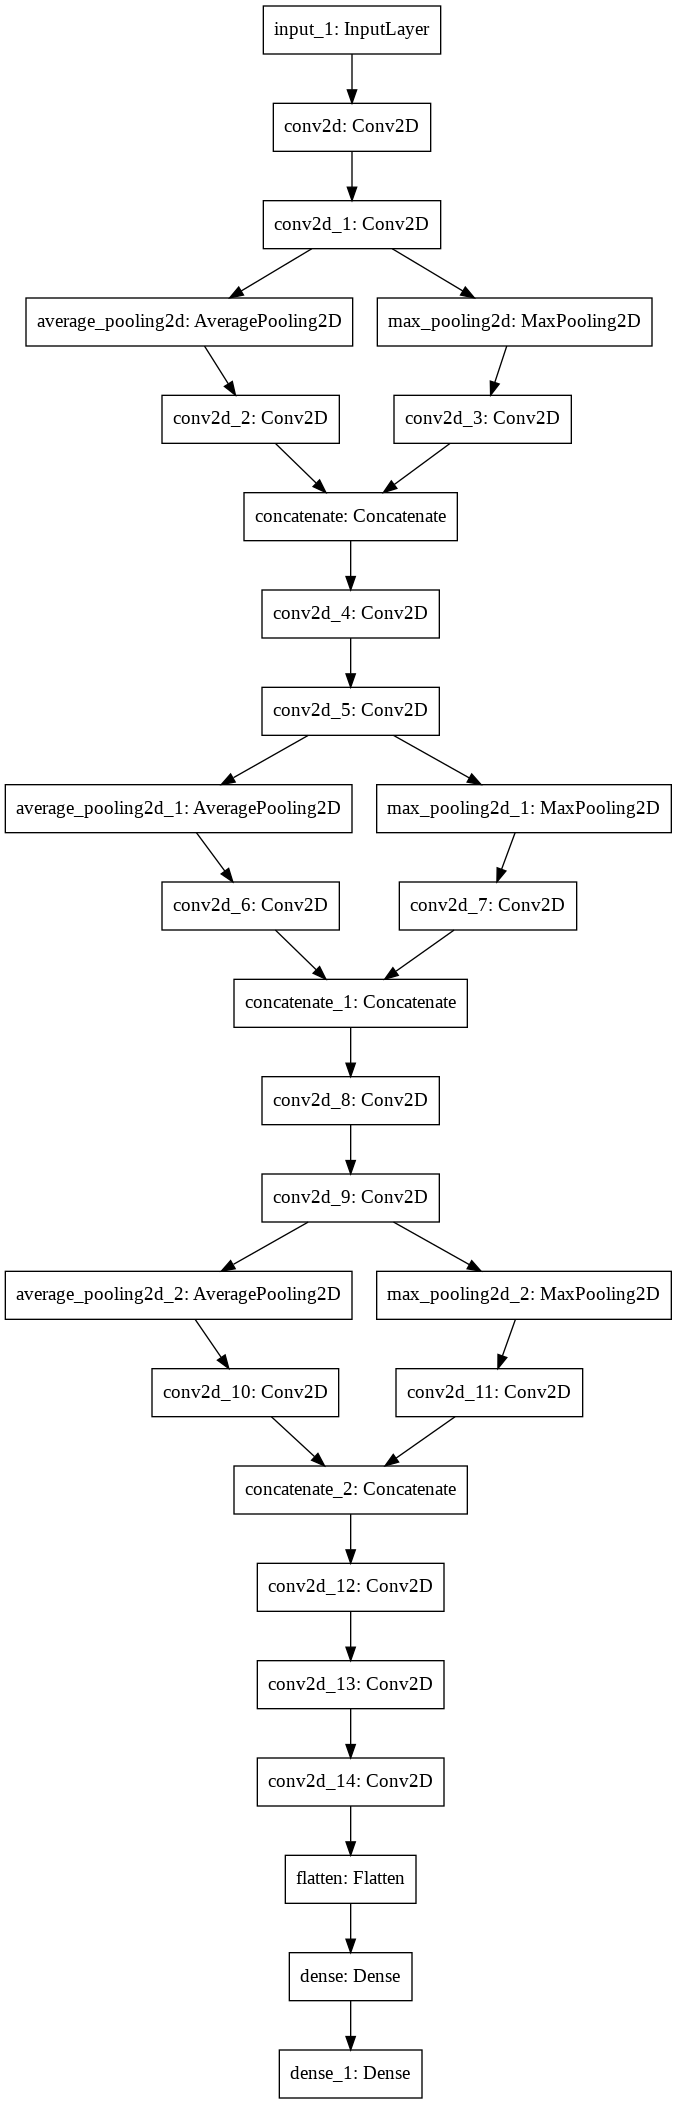

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model)

# Обучение

Epoch 1/500
150/150 [==============================] - 20s 22ms/step - loss: 0.7215 - categorical_accuracy: 0.4975 - val_loss: 0.6830 - val_categorical_accuracy: 0.5866
Epoch 2/500
150/150 [==============================] - 3s 17ms/step - loss: 0.6995 - categorical_accuracy: 0.5113 - val_loss: 0.6811 - val_categorical_accuracy: 0.5781
Epoch 3/500
150/150 [==============================] - 3s 17ms/step - loss: 0.6914 - categorical_accuracy: 0.5112 - val_loss: 0.6676 - val_categorical_accuracy: 0.5959
Epoch 4/500
150/150 [==============================] - 3s 17ms/step - loss: 0.6931 - categorical_accuracy: 0.5069 - val_loss: 0.6690 - val_categorical_accuracy: 0.5968
Epoch 5/500
150/150 [==============================] - 3s 17ms/step - loss: 0.6887 - categorical_accuracy: 0.5333 - val_loss: 0.6642 - val_categorical_accuracy: 0.6069
Epoch 6/500
150/150 [==============================] - 3s 17ms/step - loss: 0.6837 - categorical_accuracy: 0.5539 - val_loss: 0.6678 - val_categorical_accuracy

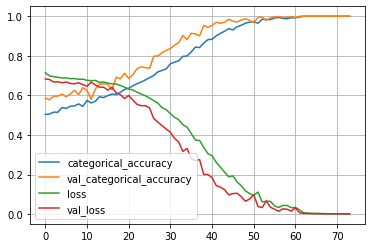

In [ ]:
model.compile(optimizer=Adam(learning_rate = 5e-05),
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy']) 

early_stopping = EarlyStopping(monitor = 'val_categorical_accuracy', patience = 12, verbose = 0, 
                               restore_best_weights = True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor=0.8, patience=4, min_lr=1e-07, verbose = 0)

model_file_name = f'{ticker}_Conv_{period}_{frame_size}_{ensemble}.h5'
checkpoint = ModelCheckpoint(model_file_name, monitor='val_categorical_accuracy', verbose = 0,
                             save_best_only = True, mode='max')

# fit model
history = model.fit(ds.train(), epochs=500, verbose = 1,
                    validation_data=ds.val(),
                    #batch_size = batch_size,
                    callbacks = [early_stopping, reduce_lr, checkpoint])


plt.figure(figsize=(6,4))
plt.plot(history.history['categorical_accuracy'], label='categorical_accuracy')
plt.plot(history.history['val_categorical_accuracy'], label='val_categorical_accuracy')
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.grid()
plt.show()

# Проверка модели

In [ ]:
model.evaluate(ds.test())

24/24 [==============================] - 0s 6ms/step - loss: 0.0133 - categorical_accuracy: 0.9996


[0.013275690376758575, 0.9995764493942261]

In [ ]:
pred = model.predict(ds.test())
ddd = ds.test_prep_dec(pred)

## Стратегия Long

In [ ]:
# Стратегия только Long (подключен класс стратегии LS)
bt = Backtest(ddd, LS, cash=cash, commission=.004, trade_on_close=True)
stats = bt.run()
bt.plot(plot_volume=True, relative_equity=True)

In [ ]:
# Проверка по идеальной разметке стратегия Long
bt = Backtest(data[ds.test_start_index + ensemble:], LS, cash=cash, commission=.004, trade_on_close=True)
stats = bt.run()
bt.plot(plot_volume=True, relative_equity=True)

## Стратегия Long & Short

In [ ]:
# Стратегия Long & Short (подключен класс стратегии LnS)
bt = Backtest(ddd, LnS, cash=cash, commission=.004, trade_on_close=True)
stats = bt.run()
bt.plot(plot_volume=True, relative_equity=True)

In [ ]:
# Проверка по идеальной разметке стратегия Long & Short
bt = Backtest(data[ds.test_start_index + ensemble:], LnS, cash=cash, commission=.004, trade_on_close=True)
stats = bt.run()
bt.plot(plot_volume=True, relative_equity=True)